In [1]:
# import os
# import zipfile

In [ ]:
# files = os.listdir('./data')

# for file in files:
#     if file[-4:] == '.zip':
        # with zipfile.ZipFile('./data/' + file, 'r') as zip_ref:
        #     zip_ref.extractall('./data/' + file[-4:])

In [1]:
!pip install lightning
!pip install torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 106.5 MB/s eta 0:00:00


In [1]:
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms

from PIL import Image

from torch.autograd import Variable
import torch, os
from torch import nn
from torchvision.datasets.vision import VisionDataset
import torchvision.models as models
from torchvision.datasets.mnist import read_image_file
from torch.nn import functional as F
from torch.utils.data import random_split, Subset, DataLoader, Dataset

from torchmetrics.classification import MulticlassAccuracy
from torchsummary import summary


import lightning.pytorch as pl


from skimage.util import random_noise

import cv2 as cv

In [2]:
root = './data'

In [3]:
class Tire_Dataset(VisionDataset):
    
    def __init__(self, root, transform = None):
        super(Tire_Dataset, self).__init__(root, transform=None)
        self.root = root
        self.transform = transform
        self.classes = ['good', 'defective']
    
    def __len__(self):
        count = 0
        for class_dir in self.classes:
            count += len(os.listdir(os.path.join(self.root, class_dir)))
        return count
    
    def __getitem__(self, idx):
        class_label = None

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root, class_name)
            num_images = len(os.listdir(class_dir))

            if idx < num_images:
                class_label = class_idx
                break
            else:
                idx -= num_images

        img_name = os.listdir(class_dir)[idx]
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(class_label)

        return image, labels

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        """
        Args:
            image (PIL.Image): Input image.

        Returns:
            PIL.Image: Image with added noise.
        """
        image = np.array(image)  # Convert to a numpy array
        noise = np.random.normal(self.mean, self.std, image.shape).astype(np.uint8)
        noisy_image = Image.fromarray(np.clip(image + noise, 0, 255), 'RGB')
        return noisy_image

In [5]:
class TireDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.custom_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Resize([256, 256]),
            # AddGaussianNoise(0,1e-2),
            # transforms.Normalize((0.5), (0.5)),
        ])

    def setup(self, stage=None):
        self.tire_dataset = Tire_Dataset(root=self.data_dir, transform=self.custom_transform)
        
        # Determine the size of the testing dataset (half the size of the whole dataset)
        total_size = len(self.tire_dataset)
        train_size = int(0.8 * total_size)
        test_size = total_size - train_size

        # Split the dataset into training and testing
        self.train_dataset, self.test_dataset = random_split(self.tire_dataset, [train_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

In [6]:
class HybridBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, cardinality, bottleneck_width):
        super(HybridBlock, self).__init__()
        out_channels = cardinality * bottleneck_width
        self.convs = nn.ModuleList()
        for _ in range(cardinality):
            # Each branch within the block
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                # nn.Dropout(0.15),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace=True),
                
                nn.Conv2d(out_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
                # nn.Dropout(0.15),
                nn.BatchNorm2d(growth_rate),
                nn.LeakyReLU(inplace=True)
            ))
            in_channels += growth_rate
        
    def forward(self, x):
        out = x
        # print(out.shape)
        for conv in self.convs:
            out = torch.cat([out, conv(out)], 1) # Pass through each branch
            # print(out.shape)
        return out

In [7]:
class HybridDenseNet(nn.Module):
    def __init__(self, growth_rate, cardinality, bottleneck_width, num_classes=10, layers = 3):
        super(HybridDenseNet, self).__init__()
        self.in_channels = 256
        self.conv = nn.Conv2d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.blocks = nn.ModuleList()
        for _ in range(layers):  # 3 layers
            self.blocks.append(self._make_block(growth_rate, cardinality, bottleneck_width))
            self.in_channels += growth_rate * cardinality
        
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, 2)
        
    def _make_block(self, growth_rate, cardinality, bottleneck_width):
        return HybridBlock(self.in_channels, growth_rate, cardinality, bottleneck_width)

    def forward(self, x):
        out = self.conv(x)  # Initial convolutional layer
        for block in self.blocks:  # Pass through each block
            out = block(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)  # Fully connected layer for classification
        return out

In [8]:
class HybridDenseNetLightning(pl.LightningModule):
    def __init__(self, model, l1_ratio = 0.0, l2_ratio = 0.0):
        super().__init__()
        self.model = model  # Your HybridDenseNet model goes here
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
        
        self.loss = torch.nn.CrossEntropyLoss()
        
        
        self.train_loss = []
        self.train_acc = []
        self.test_loss = []
        self.test_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x.float())
        
        
        loss = self.loss(logits, y)
        
        predictions = torch.argmax(logits, dim=1)
        acc = (predictions == y).sum().item() / y.size(0)
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_ratio * sum([p.abs().sum() for p in self.model.parameters()])

        #L2 regularization
        loss = loss + self.l2_ratio * sum([(p**2).sum() for p in self.model.parameters()])
        
        # if batch_idx % 10 == 9:
        #     self.train_loss.append(loss.item())
        #     self.train_acc.append(acc)

        if batch_idx % 250 == 249:
                print('[%5d], loss : %.6f, acc: %.6f' %(batch_idx + 1, loss.item(), acc))
                self.train_loss.append(loss.item())
                self.train_acc.append(acc)
                
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x.float())
        
        loss = self.loss(logits, y)
        
        predictions = torch.argmax(logits, dim=1)
        acc = (predictions == y).sum().item() / y.size(0)
        
        self.test_loss.append(loss.item())
        self.test_acc.append(acc)
        

        if batch_idx % 10 == 9:
                print('[%d], loss : %.6f, acc: %.6f' %(batch_idx + 1, loss.item(), acc))
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-6)
        return optimizer

In [9]:
batch_size = 16
tire_datamodule = TireDataModule(root, batch_size)

In [10]:
epochs = 50
trainer = pl.Trainer(accelerator = 'gpu', devices = 1, max_epochs = epochs)
net = HybridDenseNet(growth_rate=2, cardinality=3, bottleneck_width=4, num_classes=2, layers = 3)
lightning_model = HybridDenseNetLightning(net)
trainer.fit(lightning_model, tire_datamodule)
print("-" * 100)
print('Testing model..')
trainer.test(lightning_model, tire_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | HybridDenseNet   | 44.4 K
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.177     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

[  250], loss : 0.708984, acc: 0.562500
[  500], loss : 0.701159, acc: 0.437500
[  250], loss : 0.734596, acc: 0.312500
[  500], loss : 0.684077, acc: 0.625000
[  250], loss : 0.700818, acc: 0.437500
[  500], loss : 0.686811, acc: 0.562500
[  250], loss : 0.668325, acc: 0.687500
[  500], loss : 0.648008, acc: 0.750000
[  250], loss : 0.689934, acc: 0.500000
[  500], loss : 0.674310, acc: 0.625000
[  250], loss : 0.667440, acc: 0.687500
[  500], loss : 0.737338, acc: 0.375000
[  250], loss : 0.657978, acc: 0.812500
[  500], loss : 0.647234, acc: 0.625000
[  250], loss : 0.618563, acc: 0.750000
[  500], loss : 0.650650, acc: 0.562500
[  250], loss : 0.585644, acc: 0.750000
[  500], loss : 0.656815, acc: 0.625000
[  250], loss : 0.696352, acc: 0.500000
[  500], loss : 0.624594, acc: 0.625000
[  250], loss : 0.685432, acc: 0.500000
[  500], loss : 0.633677, acc: 0.625000
[  250], loss : 0.715101, acc: 0.375000
[  500], loss : 0.648827, acc: 0.625000
[  250], loss : 0.721653, acc: 0.437500


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: |          | 0/? [00:00<?, ?it/s]

[10], loss : 0.644902, acc: 0.625000
[20], loss : 0.643927, acc: 0.687500
[30], loss : 0.576322, acc: 0.687500
[40], loss : 0.606416, acc: 0.750000
[50], loss : 0.631207, acc: 0.687500
[60], loss : 0.568999, acc: 0.937500
[70], loss : 0.615018, acc: 0.812500
[80], loss : 0.691407, acc: 0.500000
[90], loss : 0.646464, acc: 0.625000
[100], loss : 0.616075, acc: 0.625000
[110], loss : 0.628091, acc: 0.500000
[120], loss : 0.720367, acc: 0.500000
[130], loss : 0.649986, acc: 0.500000
[140], loss : 0.472427, acc: 1.000000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6660681962966919     │
│         test_loss         │    0.6281585693359375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6281585693359375, 'test_accuracy': 0.6660681962966919}]

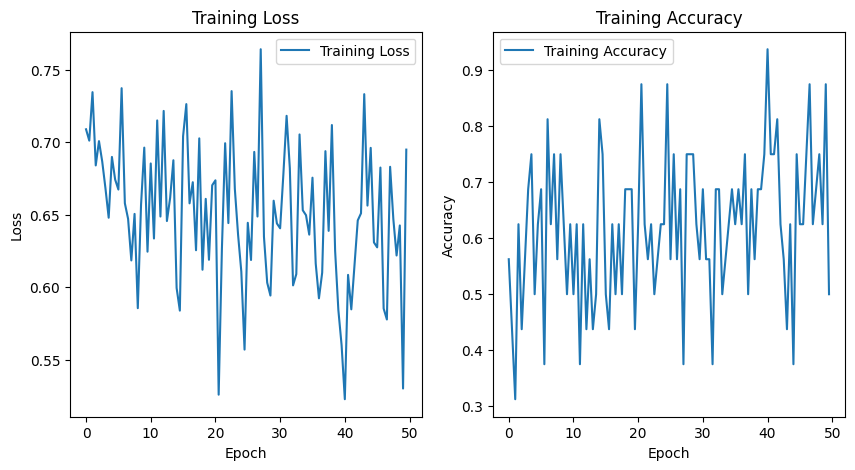

In [11]:
# Create an array with the number of epochs
x = list(np.arange(0.0, epochs, 0.5))

# Plot the loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, lightning_model.train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(x, lightning_model.train_acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

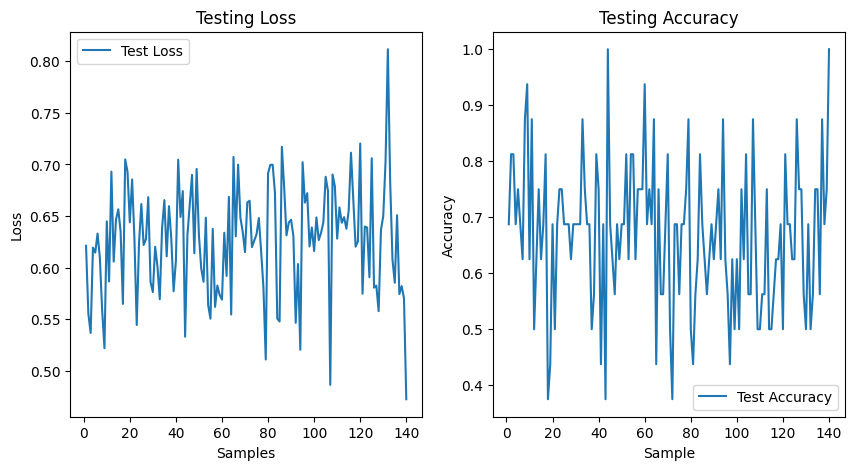

In [12]:
# Create an array with the number of epochs
epochs = [i for i in range(1, len(lightning_model.test_loss) + 1)]

# Plot the loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, lightning_model.test_loss, label='Test Loss')
plt.title('Testing Loss')
plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, lightning_model.test_acc, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Sample')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Scratch Space #

In [54]:
image_path = './data/good/good (138)_0.jpg'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image = Image.open(image_path)
input_image = transform(image).unsqueeze(0)

In [55]:
# Set the model to evaluation mode
net.eval()

# Pass the image through the model
with torch.no_grad():
    predictions = net(input_image)

# If your model outputs class probabilities, you can get the predicted class
predicted_class = torch.argmax(predictions, dim=1).item()

In [56]:
predicted_class

0

In [57]:
f_dataset = Tire_Dataset('./data/')

In [58]:
len(f_dataset)

11136

In [59]:
f_dataset[11135]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>, tensor(1))

In [60]:
f_dataset.classes

['good', 'defective']